In [2]:
import pickle
import os
import gzip
import urllib

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

In [2]:
trainset_labeled = pickle.load(open("data/train_labeled.p", "rb"))

Files already downloaded
3000
750


In [3]:
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/fig/mnist.py
def rotate_image(image, theta = 0.5):
    rot_image = np.zeros((28,28))
    def to_xy(j, k):
        # Converts from matrix indices to x, y co-ords, using the
        # 13, 14 matrix entry as the origin
        return (k-13, -j+14) # x range: -13..14, y range: -13..14
    def to_jk(x, y):
        # Converts from x, y co-ords to matrix indices
        return (-y+14, x+13)
    def image_value(image, x, y):
        j, k = to_jk(x, y)
        return image[j, k]
    for j in range(28):
        for k in range(28):
            x, y = to_xy(j, k)
            # rotate by -theta
            x1 = np.cos(theta)*x + np.sin(theta)*y
            y1 = -np.sin(theta)*x + np.cos(theta)*y
            # Nearest integer x entries are x2 and x2+1. delta_x 
            # measures how to interpolate
            x2 = np.floor(x1)
            delta_x = x1-x2
            # Similarly for y
            y2 = np.floor(y1)
            delta_y = y1-y2
            # Check if we're out of bounds, and if so continue to next entry
            # This will miss a boundary row and layer, but that's okay,
            # MNIST digits usually don't go that near the boundary.
            if x2 < -13 or x2 > 13 or y2 < -13 or y2 > 13: continue
            # If we're in bounds, average the nearby entries.
            value \
                = (1-delta_x)*(1-delta_y)*image_value(image, x2, y2)+\
                (1-delta_x)*delta_y*image_value(image, x2, y2+1)+\
                delta_x*(1-delta_y)*image_value(image, x2+1, y2)+\
                delta_x*delta_y*image_value(image, x2+1, y2+1)
            # Rescale the value by a hand-set fudge factor.  This
            # seems to be necessary because the averaging doesn't
            # quite work right.  The fudge-factor should probably be
            # theta-dependent, but I've set it by hand.  
#             rot_image[j, k] = 1.3*value
            rot_image[j, k] = int(value)# int(1.3*value)
#     plot_mnist_digit(rot_image)
    return rot_image

In [4]:
#https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [19]:
def imshow(img):
    if isinstance(img, torch.ByteTensor):
        img = img.numpy()
    if img.shape[0] > 784:
        img = img.reshape(28,28)
    
    plt.imshow(img, cmap='gray')

In [6]:
def grey_inverse(img):
    new_img = []
    for x in img:
        new_img.append(255.0-x)
    return np.array(new_img)

def sharpen(img):
    new_img = []
    for x in img:
        if x > 155: 
            x += int((255-x)/2.5)
        elif x < 100:
            x = 0
        
        new_img.append(x)
    return np.array(new_img)

In [40]:
ALPHA = 36
SIGMA = 5.5
ROTATIONS = (-0.35, 0.35)

In [42]:
new_train_data = []
new_train_labels = []

count = 0
for img, val in zip(trainset_labeled.train_data, trainset_labeled.train_labels):
    if count % 10 == 0:
        print count
    count += 1
    img = img.numpy()
    new_train_data.append(img)
    new_train_labels.append(val)

    for theta in ROTATIONS:
        new_train_data.append(rotate_image(img, theta)) 
#         new_train_data.append(sharpen(rotate_image(img, theta).flatten()).reshape(28,28))
        new_train_labels.append(val)
    for _ in xrange(2):
        img2 = elastic_transform(img, ALPHA, SIGMA)
        new_train_data.append(rotate_image(img2, theta))
        new_train_labels.append(val)
        for theta in ROTATIONS:
            new_train_data.append(rotate_image(img2, theta))        
#             new_train_data.append(sharpen(rotate_image(img, theta).flatten()).reshape(28,28))
            new_train_labels.append(val)
    
    
    

0


/Users/Alex/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [44]:
pickle.dump(new_train_data, open('data/generated_train_data.p', 'wb'))
pickle.dump(new_train_labels, open('data/generated_train_labels.p', 'wb'))

In [79]:
train_features = pickle.load(open('data/generated_train_data.p','rb'))
train_labels = pickle.load(open('data/generated_train_labels.p','rb'))

In [78]:
from sklearn.preprocessing import scale

In [80]:
train_features = [x.flatten() for x in train_features]

In [81]:
train_features = scale(train_features)

In [82]:
train_features = [x.reshape(28,28) for x in normalize(train_features)]

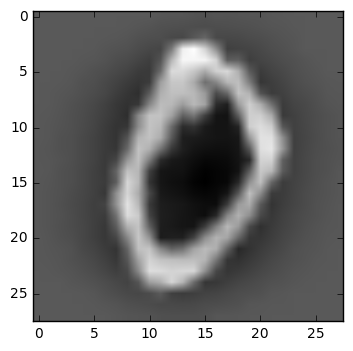

In [84]:
imshow(train_features[2])

In [74]:
validset = pickle.load(open("data/validation.p", "rb"))

In [89]:
scaled_test_data = [x.numpy().flatten() for x in validset.test_data]

In [90]:
scaled_test_data = scale(scaled_test_data)

In [95]:
scaled_test_data = [x.reshape(28,28) for x in scaled_test_data]

In [97]:
validset.test_labels


 0
 0
 0
⋮ 
 9
 9
 9
[torch.LongTensor of size 10000]

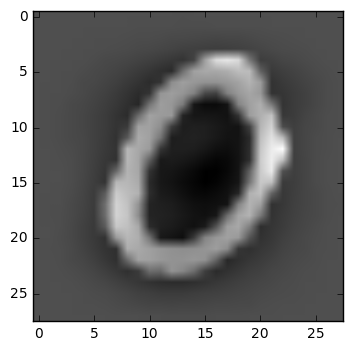

In [96]:
imshow(scaled_test_data[0])

In [4]:
train_features = torch.FloatTensor(np.array(train_features))

In [5]:
train_labels = torch.FloatTensor(np.array(train_labels))

In [6]:
train_dataset = TensorDataset(train_features, train_labels)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset)

In [31]:
train_loader.dataset.data_tensor.size()

torch.Size([27000, 28, 28])

In [15]:
trainset_labeled = pickle.load(open("data/train_labeled.p", "rb"))

In [28]:
trainset_labeled.train_data.size()

torch.Size([3000, 28, 28])

In [33]:
trainset_labeled.train_data[0]



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0    10    60
    0     0     0     0     0     0     0     0     0     0     0   163   252
    0     0     0     0     0     0     0     0     0     0    51   238   253
    0     0     0     0     0     0     0     0     0    48   238   252   252
    0     0     0     0     0     0     0     0    38   165   253   233   208
    0     0     0     0     0     0     0    

In [41]:
full_max = 0
full_min = 10
for feat in train_features:
    cur_max = max(feat.numpy().flatten())
    cur_min = min(feat.numpy().flatten())
    if cur_max > full_max:
        full_max = cur_max
    if cur_min < full_min:
        full_min = cur_min
print full_max
print full_min

255.0
0.0
